In [1]:
import copy
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from collections import deque
torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(4723156438169548417)

In [2]:
class Actor(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.tanh(self.layer4(x))
        return x


class Critic(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(n_observations+n_actions, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)

    def forward(self, x):
        x_1 = F.relu(self.layer1(x))
        x_1 = F.relu(self.layer2(x_1))
        x_1 = F.relu(self.layer3(x_1))
        x_1 = self.layer4(x_1)
        return x_1 


In [3]:

class ReplayMemory():

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, array):
        self.memory.append(array)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class Agent():
    def __init__(self,env):
        self.env = env
        n_actions = 8
        n_observations = 27
        self.replay_memory = ReplayMemory(10000)
        self.actor = Actor(n_observations, n_actions).to(device)
        self.critic = Critic(n_observations, n_actions).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_target = copy.deepcopy(self.critic)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)
        self.criterion = nn.MSELoss()
        self.cum_rewards_ddpg  = []
        self.cum_reward = 0
        
    def update_weights(self , state_dict , state_dict_):
        for key in state_dict_:
            state_dict_[key] = state_dict[key]*0.75 + state_dict_[key]*(1-0.75)
        return state_dict_
        
    def get_sample(self , size):
        memory = self.replay_memory.sample(size)
        states = torch.cat([i[0] for i in memory]).float()
        actions = torch.cat([i[1] for i in memory]).float()
        next_states = torch.cat([i[2] for i in memory]).float()
        rewards = torch.cat([i[3] for i in memory]).float()
        finals = torch.cat([i[4] for i in memory]).float()
        return states, actions, next_states, rewards, finals

    def step(self , state):
        action = self.actor(state)
        observation, reward, terminated, truncated, _ = self.env.step(action.squeeze(0).cpu().detach().numpy())
        self.cum_reward += reward
        reward = torch.tensor([reward], device=device)
        next_state = torch.zeros(len(observation) , device = device ).unsqueeze(0) if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        final = torch.tensor([False], device=device) if terminated else torch.tensor([True], device=device)
        self.replay_memory.push([state, action, next_state, reward , final])
        return next_state , terminated or truncated
           
    
    def train(self, eps):
        self.cum_reward = 0 
        for episode in tqdm(range(eps)):
            state, info = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            for iteration in range(3000):
                state, done = self.step(state)
                if done:
                    break
                elif len(self.replay_memory) < 100:
                    pass
                else:
                    states, actions, next_states, rewards , finals= self.get_sample(64)
                    next_state_actions = self.actor_target(next_states)
                    with torch.no_grad():
                        critic_next_target = self.critic_target(torch.cat([next_states, next_state_actions], 1))
                        next_q_value = rewards + finals * 0.9 * critic_next_target.squeeze(1)
                    critic_q_values = self.critic(torch.cat([states, actions], 1))
                    critic_loss = F.mse_loss(critic_q_values.squeeze(1), next_q_value)
                    
                    self.critic_optimizer.zero_grad()
                    critic_loss.backward(retain_graph = True)
                    self.critic_optimizer.step()
                    
                    actor_loss = -self.critic(torch.cat([states, self.actor(states)], 1)).mean()
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward(retain_graph = True)
                    self.actor_optimizer.step()
            self.cum_rewards_ddpg.append(self.cum_reward)
            self.cum_reward = 0
            if not episode%5:
                self.critic_target.load_state_dict(self.update_weights(self.critic.state_dict() , self.critic_target.state_dict()))
                self.actor_target.load_state_dict(self.update_weights(self.actor.state_dict() , self.actor_target.state_dict()))


In [5]:
env = gym.make('Ant-v4')
agent = Agent(env)
agent.train(100)

100%|███████████████████████████████████████| 100/100 [1:50:35<00:00, 66.35s/it]


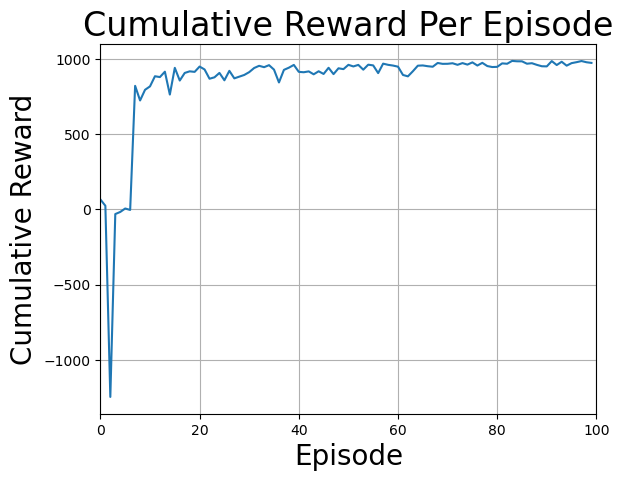

In [6]:

plt.figure()
plt.plot(agent.cum_rewards_ddpg)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode', fontsize=24)
plt.xticks(fontsize=10)
plt.xlim(xmin=0, xmax=len(agent.cum_rewards_ddpg))
plt.grid()
plt.show()

In [7]:
cum_reward = 0
cum_rewards_ = []
for episode in range(10):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    cum_rewards_.append(cum_reward)
    cum_reward = 0
    for t in range(3000):
        action = agent.actor(state)
        observation, reward, terminated, truncated, _ = env.step(action.squeeze(0).cpu().detach().numpy())
        cum_reward += reward
        next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
        if terminated or truncated:
            break

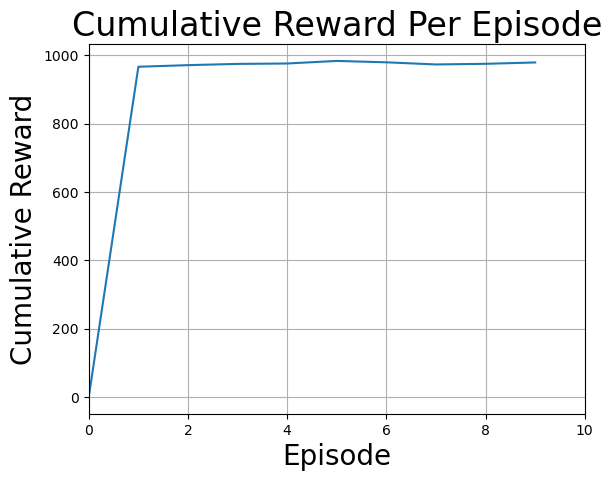

In [8]:
plt.figure()
plt.plot(cum_rewards_)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode', fontsize=24)
plt.xticks(fontsize=10)
plt.xlim(xmin=0, xmax=len(cum_rewards_))
plt.grid()
plt.show()

In [11]:
torch.save(agent.actor.state_dict(), 'ddpg_actor')
torch.save(agent.actor_target.state_dict(), 'ddpg_actor_target')
torch.save(agent.critic.state_dict(), 'ddpg_critic')
torch.save(agent.critic_target.state_dict(), 'ddpg_critic_target')